In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/fit_data.py

## Input

In [4]:
chain = 'Arbitrum'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('AUM & Glp Supply'):
        fnames['AUM & Glp Supply'] = fname
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
fnames

{'AUM & Glp Supply': 'AUM & Glp Supply_2021-08-31_2022-07-01.csv',
 'Glp Price Comparison': 'Glp Price Comparison_2021-08-31_2022-07-01.csv'}

In [6]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)

## Prep Data

In [7]:
# In the 'AUM & Glp Supply' file, col `aum` is in $, and `glpSupply` in quantity/count; 
# each row is the total stock measured at the end of the day. 
#
# I checked that `aum` == `glpSupply` * `glpPrice`, which is a col from the 'Glp Price Comparison' file.
# 
# To calculate the net GLP supply (mint amount - burn amount) for each day, 
# - take the difference of total stock of glpSupply between two consecutive dates. 
# To calculate the net dollar flow for each day, simply do
# - net supply * (daily avg) glp price, which can be taken from the price file.

daily_stock = pd.read_csv(os.path.join(data_dir, chain, fnames['AUM & Glp Supply']), 
                          parse_dates=['Date'], index_col='Date')
# drop the last row because the most recent date may not be a full day
daily_stock = daily_stock.iloc[:-1, :]
daily_stock.head()

,aum,glpSupply
Date,,
2021-08-31,"9,821.7300","8,229.0548"
2021-09-01,"1,259,345.0603","973,717.9555"
2021-09-02,"2,087,626.8657","1,620,503.2873"
2021-09-03,"2,121,438.0315","1,624,108.2897"
2021-09-04,"2,182,176.8482","1,668,759.9557"


In [8]:
# calculate daily flow by taking the difference between today's stock and yesterday's 
daily_flow = daily_stock - daily_stock.shift(1)
daily_flow.head()

,aum,glpSupply
Date,,
2021-08-31,NaN,NaN
2021-09-01,"1,249,523.3303","965,488.9007"
2021-09-02,"828,281.8054","646,785.3318"
2021-09-03,"33,811.1657","3,605.0024"
2021-09-04,"60,738.8168","44,651.6660"


In [9]:
daily_prices = pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                           parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpPrice'])
daily_prices.head()

,glpPrice
Date,
2021-08-31,1.1935
2021-09-01,1.2933
2021-09-02,1.2883
2021-09-03,1.3062
2021-09-04,1.3077


In [10]:
# calculate net dollar flow for GLP
daily_flow = (pd.merge(daily_flow, daily_prices.loc[:, 'glpPrice'], left_index=True, right_index=True)
                .assign(net_dollar_flow = lambda x: x.glpSupply * x.glpPrice))
daily_flow.head()

,aum,glpSupply,glpPrice,net_dollar_flow
Date,,,,
2021-08-31,NaN,NaN,1.1935,NaN
2021-09-01,"1,249,523.3303","965,488.9007",1.2933,"1,248,702.1227"
2021-09-02,"828,281.8054","646,785.3318",1.2883,"833,226.5943"
2021-09-03,"33,811.1657","3,605.0024",1.3062,"4,708.9158"
2021-09-04,"60,738.8168","44,651.6660",1.3077,"58,389.3636"


## GLP Net Dollar Flow 

### Monthly

In [11]:
monthly_ndf = daily_flow.groupby(daily_flow.index.to_period('M')).net_dollar_flow.sum()
monthly_ndf = monthly_ndf.iloc[1:] # drop 1st month, August 2021 since its value is 0 due to 1st day was Aug 31
monthly_ndf

Date
2021-09    30,663,878.5985
2021-10    31,574,746.0496
2021-11    44,559,864.6556
2021-12    -1,869,741.9759
2022-01    46,726,654.5248
2022-02    32,057,175.7400
2022-03    45,519,802.0586
2022-04    32,462,537.3397
2022-05     9,935,268.8713
2022-06   -33,006,399.0889
Freq: M, Name: net_dollar_flow, dtype: float64

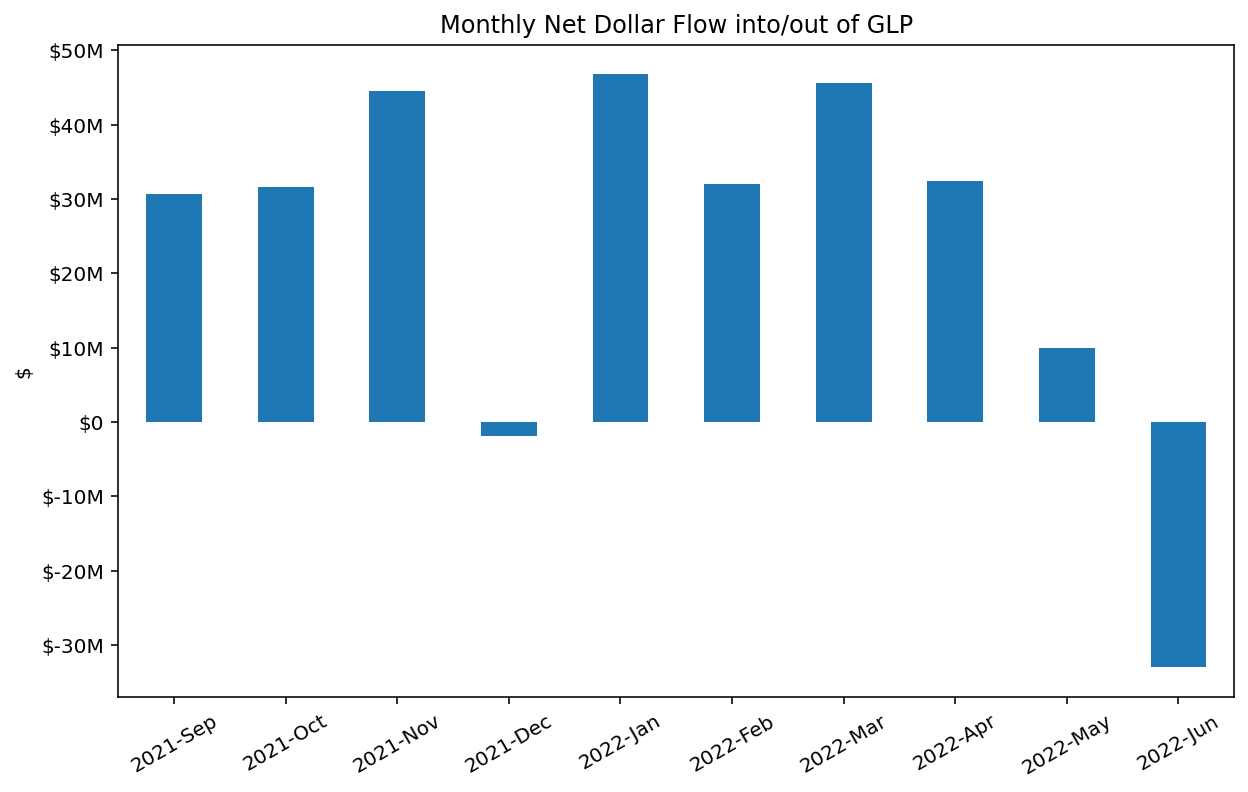

In [12]:
ax = monthly_ndf.plot(kind='bar', title="Monthly Net Dollar Flow into/out of GLP",
                      ylabel='$', xlabel='', rot=30)
ax.set_xticklabels(monthly_ndf.index.to_timestamp().strftime('%Y-%b'))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_fig_dir, 'monthly_ndf.png'), dpi=300);

- The NDF is above `$30M` for 7 out of 10 months. 
- In May 2022, Terra UST blew up, but there was still a net inflow of `~$10M` to GLP on Arbitrum.
- In June 2022, `~$33M` (net) left GLP as we entered the crypto bear market.

### Weekly

In [13]:
weekly_ndf = daily_flow.groupby(daily_flow.index.to_period('W')).net_dollar_flow.sum()
weekly_ndf.index.name = 'Week'
weekly_ndf.head()

Week
2021-08-30/2021-09-05   2,179,105.1621
2021-09-06/2021-09-12   9,562,918.0862
2021-09-13/2021-09-19   8,068,198.5426
2021-09-20/2021-09-26   8,943,695.4552
2021-09-27/2021-10-03   2,845,555.2625
Freq: W-SUN, Name: net_dollar_flow, dtype: float64

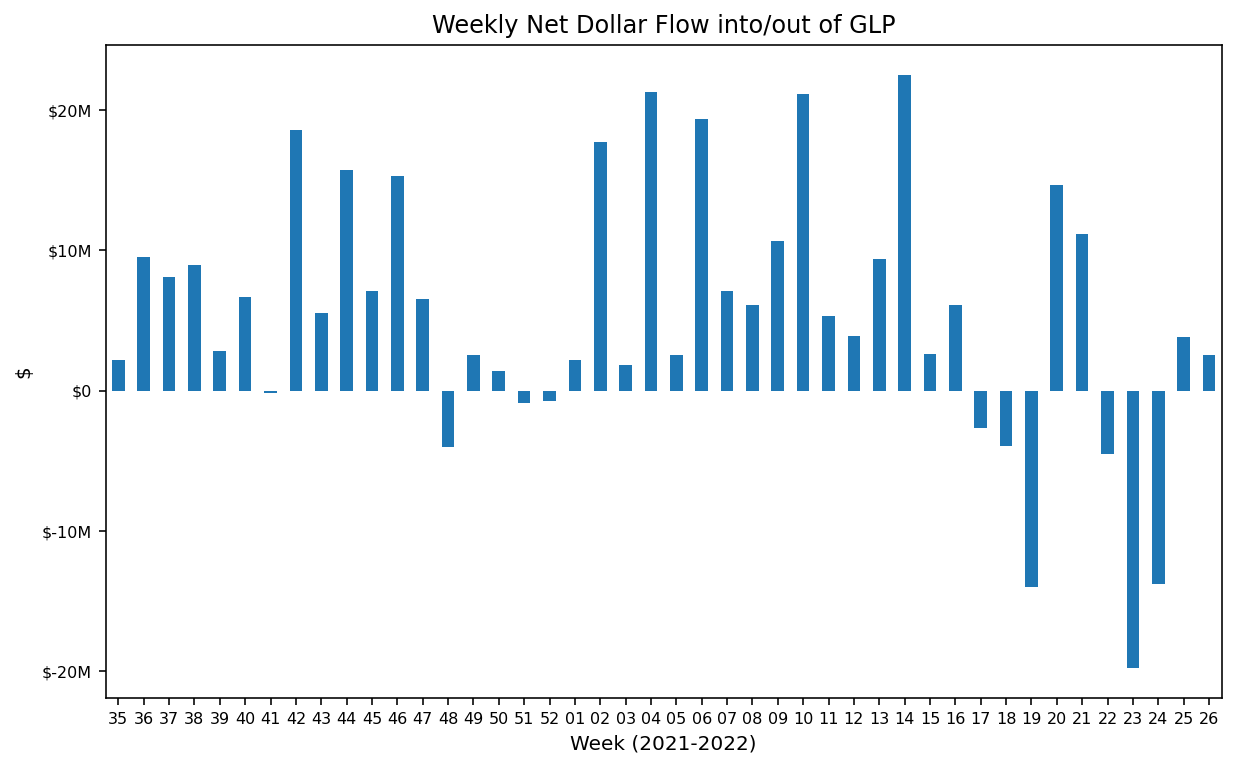

In [14]:
ax = weekly_ndf.plot(kind='bar', title="Weekly Net Dollar Flow into/out of GLP",
                     ylabel='$', xlabel='Week (2021-2022)', rot=0, fontsize=8)
ax.set_xticklabels(weekly_ndf.index.to_timestamp().strftime('%W'))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_fig_dir, 'weekly_ndf.png'), dpi=300);

### Weekly - Investigate linear trend

In [15]:
# make linear trend features for weekly level using 1, ..., nweeks
# this will make the slope of the fitted line measure unit change per week
X_weekly = (np.array(range(len(weekly_ndf.index))) + 1).reshape(-1,1) 
print(X_weekly.shape)
print(X_weekly[:5, :])

(44, 1)
[[1]
 [2]
 [3]
 [4]
 [5]]


In [16]:
# fit linear trend line
y = weekly_ndf
dd = fit_linreg(X_weekly, y) # returns a dictionary
yhat = dd['yhat']
slope = dd['slope']

intercept: 9817491.671807537 slope: -195298.8351374564


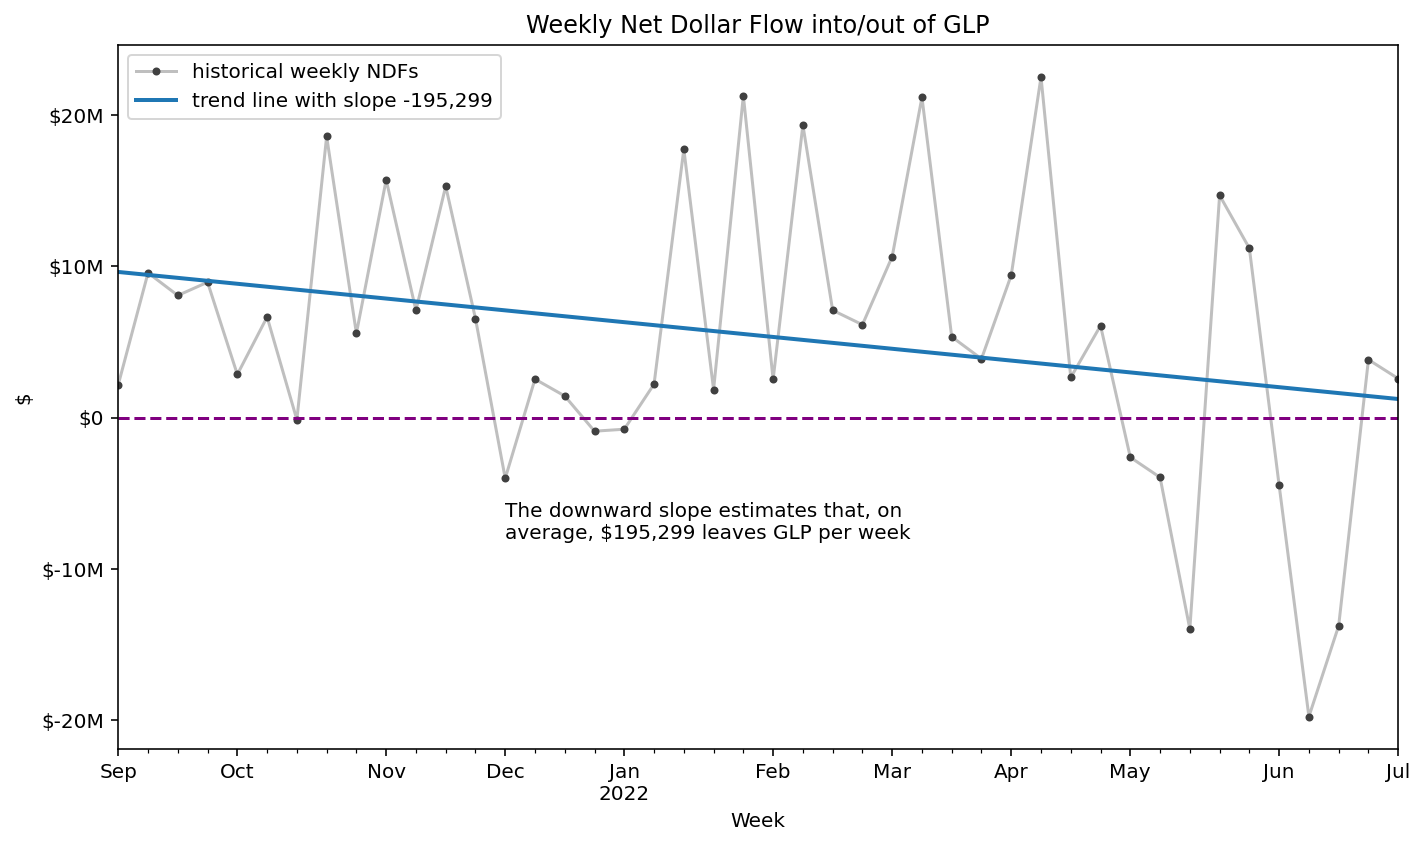

In [17]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Weekly Net Dollar Flow into/out of GLP', ylabel='$', 
    ytru_legend='historical weekly NDFs', 
    yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.axhline(0.5, linestyle='--', color='purple')
ax.text('2021-12-01', -8e6, "The downward slope estimates that, on\naverage, ${:,.0f} leaves GLP per week".format(abs(slope)))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'weekly_ndf_trend.png'), dpi=300);